In [1]:
import csv
import numpy as np
import cv2
from matplotlib import pyplot as plt
from glob import glob
import pathlib
from random import shuffle
import os

In [2]:
def csv2dic(file, numerical_data=False):
    csvfile = open(file)
    reader = csv.reader(csvfile)
    data = {}
    for header in next(reader):
        data[header] = []
    keys = list(data.keys())
    for row in reader:
        for i in range(len(keys)):
            key = keys[i]
            datum = row[i]
            if numerical_data:
                try:
                    datum = float(datum)
                except ValueError:
                    pass
            data[key].append(datum)
    return data

In [3]:
images_annotations = csv2dic('/Users/diegoeduardo/Desktop/Coral Reef Data/labels/BENTHOZ_2015_PUBLIC.csv', numerical_data=True)

In [4]:
images_annotations.keys()

dict_keys(['kpid', 'image__id', 'image_name', 'date_time', 'campaign', 'deployment', 'depth', 'label', 'code', 'x', 'y', 'latitude', 'longitude', 'altitude', 'pitch', 'roll', 'salinity', 'temperature', 'yaw', ''])

In [5]:
filenames = images_annotations['image_name']

In [6]:
len(filenames)

407968

In [7]:
from collections import Counter

In [8]:
filenames_counter = Counter(filenames)

In [9]:
filenames_counter.most_common(10)

[('PR_20120501_025301_256_LC16', 57),
 ('PR_20120501_024700_901_LC16', 57),
 ('PR_20120501_024400_724_LC16', 57),
 ('PR_20120501_023218_035_LC16', 57),
 ('PR_20120501_013249_072_LC16', 57),
 ('PR_20120501_013048_954_LC16', 57),
 ('PR_20120501_012706_925_LC16', 57),
 ('PR_20120501_010943_206_LC16', 57),
 ('PR_20120430_081446_311_LC16', 57),
 ('PR_20120501_010102_696_LC16', 57)]

In [10]:
filename = filenames_counter.most_common(1000)[0][0]

In [11]:
filename

'PR_20120501_025301_256_LC16'

In [12]:
sample_img = cv2.imread('/Users/diegoeduardo/Desktop/Coral Reef Data/images/' + filename + '.tif')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img = cv2.resize(sample_img, (224, 224), interpolation=cv2.INTER_AREA)

In [13]:
sample_img.shape

(224, 224, 3)

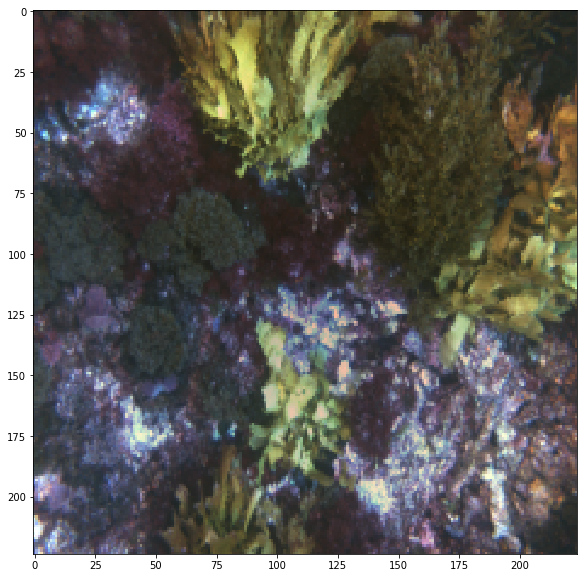

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(sample_img)

In [15]:
annotations_sample = []
for idx in range(len(filenames)):
    if filename == filenames[idx]:
        annotations_sample.append((images_annotations['x'][idx], images_annotations['y'][idx], images_annotations['label'][idx]))

In [16]:
len(annotations_sample)

57

In [17]:
id_lookups = csv2dic('/Users/diegoeduardo/Desktop/Coral Reef Data/labels/idlookups.csv')
id_lookups.keys()

dict_keys(['id', 'name'])

In [18]:
shape = sample_img.shape
annotation_ids = []
for annotation in annotations_sample:
    x = int(annotation[0]*shape[1])
    y = int(annotation[1]*shape[0])
    annotation_ids.append(id_lookups['name'][id_lookups['id'].index(str(int(annotation[2])))])
    sample_img[y-2:y+2, x-2:x+2] = (255, 0, 0)

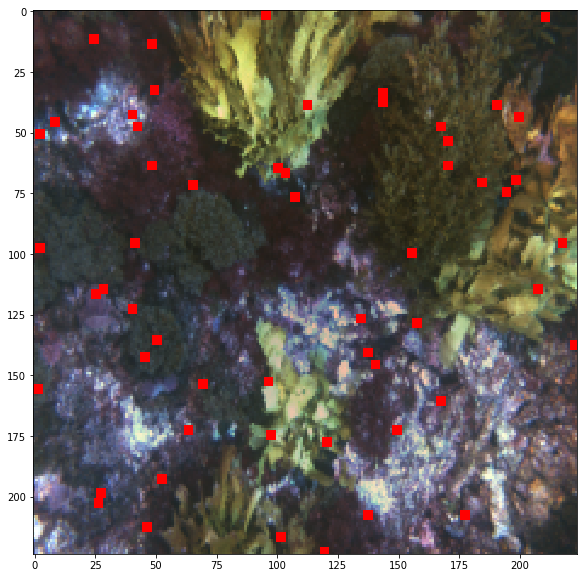

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(sample_img)

In [20]:
annotation_ids_set = Counter(annotation_ids)

In [21]:
annotation_ids_set

Counter({'Cnidaria: Corals: Stony corals: Encrusting': 3,
         'Macroalgae': 29,
         'Macroalgae: Encrusting': 10,
         'Macroalgae: Large canopy-forming: Brown': 13,
         'Sponges': 2})

In [22]:
def annotated_img(img, x, y, size):
    '''
    Returns a patch of the image 'img' containing the pixel (x, y) where an annotation was made.
    The patch has shape (size, size, channels). If the resulting patch is smaller than size x size, it'll be resized.
    '''
    shape = img.shape
    channels = shape[2]
    xStart = x - size//2
    xEnd = x + size//2
    yStart = y - size//2
    yEnd = y + size//2
    #Make sure everything is within range
    if xStart < 0:
        xEnd -= xStart
        xStart = 0
    if xEnd > shape[1]:
        xStart -= (xEnd - shape[1])
        xEnd = shape[1]
    if yStart < 0:
        yEnd -= yStart
        yStart = 0
    if yEnd > shape[0]:
        yStart -= (yEnd - shape[0])
        yEnd = shape[0]
    patch = img[yStart:yEnd, xStart:xEnd]
    if patch.shape != (size, size, channels):
        patch = cv2.resize(patch, (size, size), interpolation = cv2.INTER_CUBIC)
    return patch

In [23]:
#sample_img = cv2.imread('/Users/diegoeduardo/Desktop/Coral Reef Data/images/' + filename + '.tif')
shape = sample_img.shape
patches = []
size = 224
for annotation in annotations_sample:
    x = int(annotation[0]*shape[1])
    y = int(annotation[1]*shape[0])
    patches.append(annotated_img(sample_img, x, y, size))

In [24]:
len(patches)

57

Macroalgae: Large canopy-forming: Brown


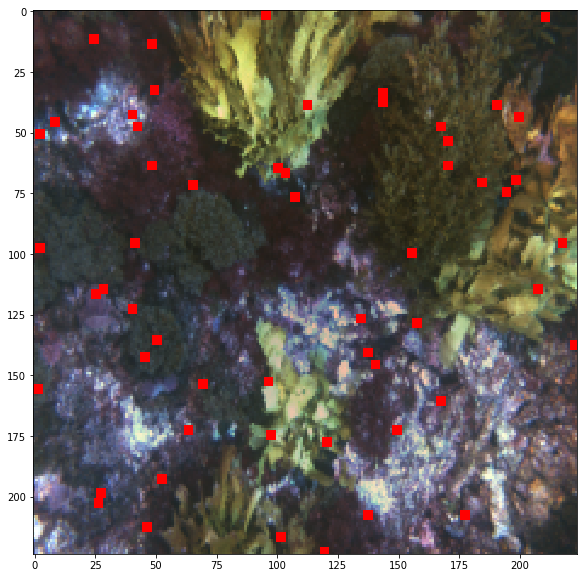

In [25]:
idx = 39
print(annotation_ids[idx])
plt.figure(figsize=(10,10))
plt.imshow(patches[idx])
plt.show()

In [33]:
labels = []
labels_num = []
for label in images_annotations['label']:
    num = int(label)
    labels_num.append(num)
    try:
        idx = id_lookups['id'].index(str(num)) 
        temp = id_lookups['name'][idx]
        labels.append(temp)
    except ValueError:
        pass
labels_counter = Counter(labels)
labels_num_counter = Counter(labels_num)

In [27]:
labels_counter.most_common()

[('Macroalgae', 98380),
 ('Substrate: Unconsolidated (soft): Sand / mud (<2mm)', 71992),
 ('Macroalgae: Large canopy-forming: Brown', 63772),
 ('Biota', 26221),
 ('Macroalgae: Encrusting: Red', 23948),
 ('Macroalgae: Encrusting', 19129),
 ('Cnidaria: Corals: Stony corals', 17974),
 ('Substrate: Unconsolidated (soft)', 15087),
 ('Cnidaria: Corals', 13154),
 ('Substrate: Consolidated (hard): Rock', 9479),
 ('Sponges', 3998),
 ('Sponges: Crusts', 3419),
 ('Macroalgae: Erect fine branching: Red', 2798),
 ('Sponges: Massive forms: Simple', 2657),
 ('Macroalgae: Large canopy-forming: Ecklonia radiata ', 2247),
 ('Cnidaria: Corals: Stony corals: Encrusting', 2194),
 ('Macroalgae: Filamentous / filiform', 1944),
 ('Substrate: Unconsolidated (soft): Pebble / gravel', 1897),
 ('Molluscs: Gastropods', 1845),
 ('Macroalgae: Articulated calcareous: Red', 1510),
 ('Macroalgae: Erect coarse branching: Green', 1491),
 ('Substrate: Unconsolidated (soft): Pebble / gravel: Biologenic', 1142),
 ('Sponges:

In [41]:
most_common_labels = []
for c in labels_num_counter.most_common(27):
    most_common_labels.append(c[0])

In [42]:
most_common_labels

[39,
 241,
 45,
 2,
 67,
 66,
 127,
 240,
 126,
 253,
 273,
 13,
 28,
 59,
 16,
 400,
 137,
 54,
 245,
 33,
 71,
 64,
 655,
 248,
 27,
 239,
 29]

In [28]:
images_in_dir = glob('/Users/diegoeduardo/Desktop/Coral Reef Data/images/*tif')

In [29]:
images_in_dir[:10]

['/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20120430_073523_701_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20120501_023218_035_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20110410_022431_443_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20110415_034831_377_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20121128_203614_706_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20110412_083231_443_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20120827_041944_982_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20110413_032215_027_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20121128_033309_792_LC16.tif',
 '/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20120904_005838_706_LC16.tif']

In [30]:
filenames_dir = []
for file_name in images_in_dir:
    temp = file_name.split('/')[-1].split('.')[0]
    filenames_dir.append(temp)

In [31]:
filenames_dir[:10]

['PR_20120430_073523_701_LC16',
 'PR_20120501_023218_035_LC16',
 'PR_20110410_022431_443_LC16',
 'PR_20110415_034831_377_LC16',
 'PR_20121128_203614_706_LC16',
 'PR_20110412_083231_443_LC16',
 'PR_20120827_041944_982_LC16',
 'PR_20110413_032215_027_LC16',
 'PR_20121128_033309_792_LC16',
 'PR_20120904_005838_706_LC16']

In [181]:
annotations_by_img = {}

for idx, file in enumerate(filenames_dir):
    keys = list(annotations_by_img.keys())
    if images_in_dir[idx] not in keys:
        annotations_by_img[images_in_dir[idx]] = []
    for jdx, name in enumerate(images_annotations['image_name']):
        if file == name:
            temp = (images_annotations['x'][jdx], images_annotations['y'][jdx], images_annotations['label'][jdx])
            annotations_by_img[images_in_dir[idx]].append(temp)

In [44]:
annotations_by_img_reduced = {} #includes only 27 most common classes (at least 1000 examples)
for idx, file in enumerate(filenames_dir):
    keys = list(annotations_by_img_reduced.keys())
    if images_in_dir[idx] not in keys:
        annotations_by_img_reduced[images_in_dir[idx]] = []
    for jdx, name in enumerate(images_annotations['image_name']):
        if file == name:
            l =  images_annotations['label'][jdx]
            if l in most_common_labels:
                temp = (images_annotations['x'][jdx], images_annotations['y'][jdx], l)
                annotations_by_img_reduced[images_in_dir[idx]].append(temp)

In [45]:
annotations_by_img_reduced[images_in_dir[0]]

[(0.843982752, 0.090423453, 655.0),
 (0.488239906, 0.768469055, 39.0),
 (0.723098785, 0.770488599, 39.0),
 (0.721334771, 0.832508143, 39.0),
 (0.345697766, 0.185798046, 39.0),
 (0.49377695, 0.91237785, 39.0),
 (0.50372403, 0.665537459, 39.0),
 (0.047138377, 0.277654723, 66.0),
 (0.216336731, 0.438045603, 66.0),
 (0.585358683, 0.236482085, 39.0),
 (0.374656997, 0.270944625, 39.0),
 (0.404155233, 0.351140065, 39.0),
 (0.439435515, 0.434788274, 39.0),
 (0.497745982, 0.755439739, 66.0),
 (0.308996472, 0.352117264, 66.0),
 (0.43502548, 0.157459283, 66.0),
 (0.698500588, 0.966254072, 66.0),
 (0.701097609, 0.397003257, 66.0),
 (0.205997648, 0.861628664, 39.0),
 (0.058506468, 0.277198697, 39.0),
 (0.764014112, 0.634592834, 39.0),
 (0.668610349, 0.625276873, 39.0),
 (0.789641317, 0.008925081, 39.0),
 (0.697324579, 0.521824104, 39.0),
 (0.155331243, 0.055504886, 39.0),
 (0.018326147, 0.409446254, 39.0),
 (0.623382987, 0.791726384, 39.0),
 (0.718198746, 0.715374593, 39.0),
 (0.277342219, 0.483257

In [80]:
directory = '/Users/diegoeduardo/Desktop/Coral Reef Data/annotated images/'

In [81]:
size = 224

for i, img_dir in enumerate(images_in_dir):
    img = cv2.imread(img_dir)
    shape = img.shape
    fname = filenames_dir[i]
    for j, annotation in enumerate(annotations_by_img_reduced[img_dir]):
        x = int(annotation[0]*shape[1])
        y = int(annotation[1]*shape[0])
        label = str(int(annotation[2]))
        path_folder = directory + label
        pathlib.Path(path_folder).mkdir(exist_ok = True)
        path_file = path_folder + '/' + fname + '_' + str(j) + '.jpg'
        patch = annotated_img(img, x, y, size)
        cv2.imwrite(path_file, patch)

This is to separate train set from test and validation sets. All files are currently in train folder, so 15% will be moved to validation folder and 15% to test folder.

In [83]:
path_train = directory + 'train/'
ls_categories = glob(path_train + '*')
len(ls_categories)

27

In [84]:
path_valid = directory + 'valid/'
path_test = directory + 'test/'

In [86]:
for path in ls_categories:
    category = path.split('/')[-1]
    pathlib.Path(path_valid + category).mkdir(exist_ok=True)
    pathlib.Path(path_test + category).mkdir(exist_ok=True)

In [87]:
for path in ls_categories:
    category = path.split('/')[-1]
    ls_samples = glob(path_train + category + '/*')
    shuffle(ls_samples)
    length = len(ls_samples)
    first_cut = int(length*0.15)
    second_cut = int(length*0.3)
    valid_set = ls_samples[:first_cut]
    test_set = ls_samples[first_cut:second_cut]
    for sample in valid_set:
        fname = sample.split('/')[-1]
        os.rename(sample, path_valid + category + '/' + fname)
    for sample in test_set:
        fname = sample.split('/')[-1]
        os.rename(sample, path_test + category + '/' + fname)

This is to subsample classes with many examples

In [89]:
dir_balanced = '/Users/diegoeduardo/Desktop/Coral Reef Data/annotated images balanced/'
path_train_balanced = dir_balanced + 'train/'
path_valid_balanced = dir_balanced + 'valid/'
path_test_balanced = dir_balanced + 'test/'

In [90]:
for path in ls_categories:
    category = path.split('/')[-1]
    pathlib.Path(path_train_balanced + category).mkdir(exist_ok=True)
    pathlib.Path(path_valid_balanced + category).mkdir(exist_ok=True)
    pathlib.Path(path_test_balanced + category).mkdir(exist_ok=True)

In [91]:
from shutil import copyfile

In [94]:
for path in ls_categories:
    category = path.split('/')[-1]
    ls_samples_train = glob(path_train + category + '/*')
    ls_samples_valid = glob(path_valid+ category + '/*')
    ls_samples_test = glob(path_test + category + '/*')
    shuffle(ls_samples_train)
    shuffle(ls_samples_valid)
    shuffle(ls_samples_test)
    length_train = 500
    length_val_test = 100
    for sample in ls_samples_train[:length_train]:
        fname = sample.split('/')[-1]
        copyfile(sample, path_train_balanced + category + '/' + fname)
    for sample in ls_samples_valid[:length_val_test]:
        fname = sample.split('/')[-1]
        copyfile(sample, path_valid_balanced + category + '/' + fname)
    for sample in ls_samples_test[:length_val_test]:
        fname = sample.split('/')[-1]
        copyfile(sample, path_test_balanced + category + '/' + fname)

This is to create an HDF5 dataset (multilabel classification)

In [48]:
import h5py

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [49]:
labels_unique = images_annotations['label']
print(len(labels_unique))
labels_unique = list(set(labels_unique))
print(len(labels_unique))

407968
145


In [50]:
len(filenames_dir)

9078

In [52]:
#num_labels = len(labels_unique)
num_labels = len(most_common_labels) #for the reduced dataset
num_images = len(filenames_dir)
y_true = np.zeros((num_images, num_labels), dtype=np.int8)

for i, fname in enumerate(images_in_dir):
    for j, lab in enumerate(most_common_labels):
        #for ann in annotations_by_img[fname]:
        for ann in annotations_by_img_reduced[fname]:
            if ann[2] == lab:
                y_true[i][j] = 1

In [53]:
y_true.shape

(9078, 27)

In [54]:
y_true[:10]

array([[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]], dtype=int8)

In [55]:
print(images_in_dir[0])
annotations_by_img_reduced[images_in_dir[0]]

/Users/diegoeduardo/Desktop/Coral Reef Data/images/PR_20120430_073523_701_LC16.tif


[(0.843982752, 0.090423453, 655.0),
 (0.488239906, 0.768469055, 39.0),
 (0.723098785, 0.770488599, 39.0),
 (0.721334771, 0.832508143, 39.0),
 (0.345697766, 0.185798046, 39.0),
 (0.49377695, 0.91237785, 39.0),
 (0.50372403, 0.665537459, 39.0),
 (0.047138377, 0.277654723, 66.0),
 (0.216336731, 0.438045603, 66.0),
 (0.585358683, 0.236482085, 39.0),
 (0.374656997, 0.270944625, 39.0),
 (0.404155233, 0.351140065, 39.0),
 (0.439435515, 0.434788274, 39.0),
 (0.497745982, 0.755439739, 66.0),
 (0.308996472, 0.352117264, 66.0),
 (0.43502548, 0.157459283, 66.0),
 (0.698500588, 0.966254072, 66.0),
 (0.701097609, 0.397003257, 66.0),
 (0.205997648, 0.861628664, 39.0),
 (0.058506468, 0.277198697, 39.0),
 (0.764014112, 0.634592834, 39.0),
 (0.668610349, 0.625276873, 39.0),
 (0.789641317, 0.008925081, 39.0),
 (0.697324579, 0.521824104, 39.0),
 (0.155331243, 0.055504886, 39.0),
 (0.018326147, 0.409446254, 39.0),
 (0.623382987, 0.791726384, 39.0),
 (0.718198746, 0.715374593, 39.0),
 (0.277342219, 0.483257

In [58]:
print(
most_common_labels.index(655.0),
most_common_labels.index(39.0),
most_common_labels.index(45.0),
most_common_labels.index(66.0),
)

22 0 2 5


In [210]:
len(y_true)

9078

In [59]:
images_in_dir_arr = np.squeeze(np.asarray(images_in_dir))

In [60]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [61]:
images_in_dir_arr, y_true = shuffle_in_unison(images_in_dir_arr, y_true)

In [62]:
ex = images_in_dir_arr[0]

In [64]:
annotations_by_img_reduced[ex]

[(0.107176142, 0.567157374, 127.0),
 (0.006916172, 0.076862949, 127.0),
 (0.268112032, 0.463522668, 127.0),
 (0.070437043, 0.663561751, 127.0),
 (0.724039829, 0.38933038, 127.0),
 (0.136361407, 0.662519541, 127.0),
 (0.190219257, 0.21756123, 127.0),
 (0.075145926, 0.840997916, 127.0),
 (0.147594055, 0.761920271, 127.0),
 (0.11556384, 0.614643043, 127.0),
 (0.011723157, 0.705184992, 127.0),
 (0.225192525, 0.641805628, 127.0),
 (0.094079561, 0.274426785, 127.0),
 (0.83229509, 0.17828296, 127.0),
 (0.799725315, 0.145909328, 127.0),
 (0.577181537, 0.622394476, 137.0),
 (0.59263256, 0.881057843, 137.0),
 (0.396527199, 0.982477853, 137.0),
 (0.573012214, 0.664213132, 137.0),
 (0.491293471, 0.940203231, 137.0),
 (0.627311522, 0.607868682, 137.0),
 (0.547358611, 0.772733194, 137.0),
 (0.357090303, 0.982542991, 137.0),
 (0.940354147, 0.337806149, 126.0),
 (0.960514053, 0.115554977, 126.0),
 (0.226271644, 0.001563314, 126.0),
 (0.280865257, 0.871221991, 126.0),
 (0.975817923, 0.697107869, 126.0)

In [66]:
y_true[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int8)

In [65]:
print(
most_common_labels.index(126),
most_common_labels.index(127),
most_common_labels.index(137),)

8 6 16


In [67]:
train_addrs = images_in_dir_arr[0:int(0.7*len(images_in_dir_arr))]
train_labels = y_true[0:int(0.7*len(y_true))]
len(train_addrs) == len(train_labels)

True

In [68]:
val_addrs = images_in_dir_arr[int(0.7*len(images_in_dir_arr)):int(0.85*len(images_in_dir_arr))]
val_labels = y_true[int(0.7*len(y_true)):int(0.85*len(y_true))]
len(val_addrs) == len(val_labels)

True

In [69]:
test_addrs = images_in_dir_arr[int(0.85*len(images_in_dir_arr)):]
test_labels = y_true[int(0.85*len(y_true)):]
len(test_addrs) == len(test_labels)

True

In [70]:
hdf5_path = '/Users/diegoeduardo/Desktop/Coral Reef Data/dataset/mlb_data_reduced.hdf5'
hdf5_file = h5py.File(hdf5_path, mode='w')

train_shape = (len(train_addrs), 224, 224, 3)
val_shape = (len(val_addrs), 224, 224, 3)
test_shape = (len(test_addrs), 224, 224, 3)


hdf5_file.create_dataset("train_img", train_shape, np.uint8)
hdf5_file.create_dataset("val_img", val_shape, np.uint8)
hdf5_file.create_dataset("test_img", test_shape, np.uint8)
hdf5_file.create_dataset("train_labels", (len(train_addrs), num_labels), np.uint8)
hdf5_file["train_labels"][...] = train_labels
hdf5_file.create_dataset("val_labels", (len(val_addrs), num_labels), np.uint8)
hdf5_file["val_labels"][...] = val_labels
hdf5_file.create_dataset("test_labels", (len(test_addrs), num_labels), np.uint8)
hdf5_file["test_labels"][...] = test_labels

In [71]:
# loop over train addresses
for i in range(len(train_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = train_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img/255.
    
    hdf5_file["train_img"][i] = img

# loop over validation addresses
for i in range(len(val_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print('Validation data: {}/{}'.format(i, len(val_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = val_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img/255.
    # save the image
    hdf5_file["val_img"][i] = img
# loop over test addresses
for i in range(len(test_addrs)):
    # print how many images are saved every 1000 images
    if i % 1000 == 0 and i > 1:
        print('Test data: {}/{}'.format(i, len(test_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = test_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img/255.
    # save the image
    hdf5_file["test_img"][i] = img

hdf5_file.close()

Train data: 1000/6354
Train data: 2000/6354
Train data: 3000/6354
Train data: 4000/6354
Train data: 5000/6354
Train data: 6000/6354
Validation data: 1000/1362
Test data: 1000/1362


In [72]:
hdf5_file = h5py.File(hdf5_path, "r")
hdf5_file["train_img"][0][:5]

array([[[46, 61, 87],
        [43, 59, 69],
        [57, 74, 93],
        ...,
        [41, 41, 40],
        [36, 41, 41],
        [31, 38, 43]],

       [[58, 86, 95],
        [62, 80, 64],
        [51, 61, 64],
        ...,
        [41, 38, 35],
        [39, 40, 37],
        [40, 41, 40]],

       [[71, 85, 74],
        [79, 78, 55],
        [45, 43, 42],
        ...,
        [39, 35, 34],
        [39, 39, 34],
        [37, 38, 37]],

       [[59, 66, 79],
        [58, 60, 68],
        [37, 41, 44],
        ...,
        [36, 33, 36],
        [39, 35, 33],
        [37, 38, 35]],

       [[56, 71, 89],
        [58, 74, 84],
        [58, 70, 54],
        ...,
        [35, 35, 39],
        [40, 34, 34],
        [40, 38, 33]]], dtype=uint8)

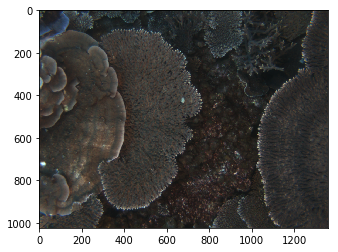

In [73]:
plt.imshow(cv2.cvtColor(cv2.imread(train_addrs[0]), cv2.COLOR_BGR2RGB))

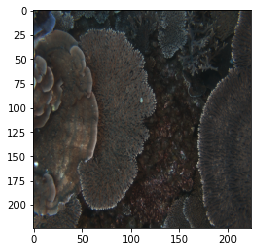

In [74]:
plt.imshow(hdf5_file["train_img"][0]/255.)

In [75]:
l = hdf5_file["train_labels"]

In [76]:
l[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=uint8)

In [77]:
hdf5_file.close()

In [311]:
labels_unique

[2.0,
 4.0,
 5.0,
 7.0,
 8.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 32.0,
 33.0,
 34.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 80.0,
 81.0,
 87.0,
 88.0,
 89.0,
 90.0,
 92.0,
 93.0,
 97.0,
 100.0,
 102.0,
 115.0,
 118.0,
 119.0,
 120.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 131.0,
 133.0,
 134.0,
 136.0,
 137.0,
 139.0,
 141.0,
 655.0,
 144.0,
 145.0,
 658.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 152.0,
 146.0,
 154.0,
 155.0,
 153.0,
 156.0,
 158.0,
 159.0,
 160.0,
 161.0,
 162.0,
 163.0,
 164.0,
 165.0,
 166.0,
 167.0,
 168.0,
 169.0,
 170.0,
 171.0,
 172.0,
 174.0,
 143.0,
 228.0,
 231.0,
 232.0,
 233.0,
 234.0,
 235.0,
 236.0,
 237.0,
 239.0,
 240.0,
 241.0,
 245.0,
 248.0,
 249.0,
 252.0,


In [78]:
import pickle
with open('/Users/diegoeduardo/Desktop/Coral Reef Data/dataset/classes_reduced.txt', "wb") as fp:
    pickle.dump(most_common_labels, fp)